In [1]:
import numpy as np
import pandas as pd 
from sklearn.metrics import r2_score, mean_squared_error
import sys
import os
from joblib import load
import matplotlib.pyplot as plt
# make paths above 'notebooks/' visible for local imports.
# +----------------------------------------------------------------------------+
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.processing import GatherFeatureDatasets
from src import plotting

In [2]:

def get_depth_baz_results(selected_feat_dict, 
                          station_meta_dict,
                          phase,
                          model_dir,
                          all_train_df,
                          depth_ind,
                          baz_ind):
    depth_r2_summary = {}
    baz_r2_summary = {}
    for stat in selected_feat_dict.keys():
        print(f'{stat}.{phase}.scaler.joblib',  f'{stat}.{phase}.SVR.joblib')
        scaler = load(os.path.join(model_dir, f'{stat}.{phase}.scaler.joblib'))
        svm_model = load(os.path.join(model_dir, f'{stat}.{phase}.SVR.joblib'))
        mean_depth = all_train_df[all_train_df.station == stat].drop_duplicates('Evid')['source_depth_km'].mean()
        mean_baz = all_train_df[all_train_df.station == stat].drop_duplicates('Evid')['source_receiver_back_azimuth'].mean()
        print(mean_depth, mean_baz)
        stat_depth = {}
        stat_baz = {}
        for ds in ['test', 'holdout']:
            if selected_feat_dict[stat][f'X_{ds}'] is None:
                stat_depth[f'{ds}_r2'] = None
                stat_baz[f'{ds}_r2'] = None
                continue

            X_depth = np.copy(selected_feat_dict[stat][f'X_{ds}'])
            X_depth[:, depth_ind] = mean_depth

            X_baz = np.copy(selected_feat_dict[stat][f'X_{ds}'])
            X_baz[:, baz_ind] = mean_baz   

            yhat_depth = svm_model.predict(scaler.transform(X_depth))
            yhat_baz = svm_model.predict(scaler.transform(X_baz))

            depth_r2 = r2_score(station_meta_dict[stat][f'y_{ds}'], yhat_depth)
            baz_r2 = r2_score(station_meta_dict[stat][f'y_{ds}'], yhat_baz)

            stat_depth[f'{ds}_r2'] = depth_r2
            stat_baz[f'{ds}_r2'] = baz_r2

        depth_r2_summary[stat] = stat_depth
        baz_r2_summary[stat] = stat_baz

    return pd.DataFrame(depth_r2_summary).T, pd.DataFrame(baz_r2_summary).T

In [3]:
magdir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes'
data_dir = os.path.join(magdir, 'feature_splits')

In [4]:
selected_features = ['amp_1', 'amp_2','signal_variance',
                    'noise_variance', 'source_depth_km',
                    'source_receiver_distance_logkm',
                    'source_receiver_back_azimuth_deg']

# Get P results

In [5]:
pproc = GatherFeatureDatasets(is_p=True)

In [6]:
pmodel_dir = os.path.join(magdir, 'p_models/selected_features_constHP')
p_all_train_df = pd.read_csv(f'{data_dir}/p.train.csv')
p_all_test_df = pd.read_csv(f'{data_dir}/p.test.csv')
p_all_holdout_df = pd.read_csv(f'{data_dir}/p.20230101.csv')
p_results = pd.read_csv(os.path.join(pmodel_dir, 'all.stat.results.csv'))

In [7]:
pproc = GatherFeatureDatasets(is_p=True)
p_station_feature_dict, p_station_meta_dict, p_feature_names = pproc.process_all_stations_datasets(p_all_train_df, 
                                                                  p_all_test_df,
                                                                  holdout_df=p_all_holdout_df,
                                                                  scaler=False,
                                                                  linear_model=False,
                                                                  source_dist_type='dist')

p_selected_feat_dict, p_selected_feature_names = pproc.filter_station_dict_features(p_station_feature_dict,
                                                                             p_feature_names,
                                                                             selected_features)

p_depth_ind = np.where(p_selected_feature_names == 'source_depth_km')[0]
p_baz_ind = np.where(p_selected_feature_names == 'source_receiver_back_azimuth_deg')[0]

p_depth_r2_df, p_baz_r2_df = get_depth_baz_results(p_selected_feat_dict,
                                               p_station_meta_dict,
                                               'P',
                                               pmodel_dir,
                                               p_all_train_df,
                                               p_depth_ind,
                                               p_baz_ind)

YHB
X shape: (3580, 45), y shape: (3580,)
X shape: (897, 45), y shape: (897,)
X shape: (363, 45), y shape: (363,)
YDC
X shape: (2928, 45), y shape: (2928,)
X shape: (725, 45), y shape: (725,)
X shape: (29, 45), y shape: (29,)
YWB
X shape: (3780, 45), y shape: (3780,)
X shape: (913, 45), y shape: (913,)
X shape: (357, 45), y shape: (357,)
MCID
X shape: (3389, 45), y shape: (3389,)
X shape: (832, 45), y shape: (832,)
X shape: (311, 45), y shape: (311,)
YHL
X shape: (3213, 45), y shape: (3213,)
X shape: (812, 45), y shape: (812,)
X shape: (374, 45), y shape: (374,)
YMR
X shape: (4154, 45), y shape: (4154,)
X shape: (1071, 45), y shape: (1071,)
X shape: (446, 45), y shape: (446,)
YHH
X shape: (4813, 45), y shape: (4813,)
X shape: (1215, 45), y shape: (1215,)
X shape: (397, 45), y shape: (397,)
B207
X shape: (1718, 45), y shape: (1718,)
X shape: (411, 45), y shape: (411,)
YPP
X shape: (1558, 45), y shape: (1558,)
X shape: (399, 45), y shape: (399,)
X shape: (217, 45), y shape: (217,)
YPM
X 

# Get S Results

In [8]:
smodel_dir = os.path.join(magdir, 's_models/selected_features_constHP')
s_all_train_df = pd.read_csv(f'{data_dir}/s.train.csv')
s_all_test_df = pd.read_csv(f'{data_dir}/s.test.csv')
s_all_holdout_df = pd.read_csv(f'{data_dir}/s.20230101.csv')
s_results = pd.read_csv(os.path.join(smodel_dir, 'all.stat.results.csv'))

In [9]:
sproc = GatherFeatureDatasets(is_p=False)
s_station_feature_dict, s_station_meta_dict, s_feature_names = sproc.process_all_stations_datasets(s_all_train_df, 
                                                                  s_all_test_df,
                                                                  holdout_df=s_all_holdout_df,
                                                                  scaler=False,
                                                                  linear_model=False,
                                                                  source_dist_type='dist')

s_selected_feat_dict, s_selected_feature_names = sproc.filter_station_dict_features(s_station_feature_dict,
                                                                             s_feature_names,
                                                                             selected_features)

s_depth_ind = np.where(s_selected_feature_names == 'source_depth_km')[0]
s_baz_ind = np.where(s_selected_feature_names == 'source_receiver_back_azimuth_deg')[0]

s_depth_r2_df, s_baz_r2_df = get_depth_baz_results(s_selected_feat_dict,
                                               s_station_meta_dict,
                                               'S',
                                               smodel_dir,
                                               s_all_train_df,
                                               s_depth_ind,
                                               s_baz_ind)

YHB
X shape: (1248, 45), y shape: (1248,)
X shape: (331, 45), y shape: (331,)
X shape: (225, 45), y shape: (225,)
YHL
X shape: (537, 45), y shape: (537,)
X shape: (133, 45), y shape: (133,)
X shape: (39, 45), y shape: (39,)
YMR
X shape: (1533, 45), y shape: (1533,)
X shape: (392, 45), y shape: (392,)
X shape: (172, 45), y shape: (172,)
YHH
X shape: (1222, 45), y shape: (1222,)
X shape: (328, 45), y shape: (328,)
X shape: (113, 45), y shape: (113,)
B207
X shape: (341, 45), y shape: (341,)
X shape: (83, 45), y shape: (83,)
FLWY
X shape: (319, 45), y shape: (319,)
X shape: (89, 45), y shape: (89,)
X shape: (12, 45), y shape: (12,)
YUF
X shape: (816, 45), y shape: (816,)
X shape: (227, 45), y shape: (227,)
X shape: (118, 45), y shape: (118,)
YPP
X shape: (189, 45), y shape: (189,)
X shape: (58, 45), y shape: (58,)
X shape: (35, 45), y shape: (35,)
YNR
X shape: (2090, 45), y shape: (2090,)
X shape: (541, 45), y shape: (541,)
X shape: (99, 45), y shape: (99,)
YML
X shape: (423, 45), y shape:

In [10]:
s_depth_r2_df.head()

,test_r2,holdout_r2
YHB,0.809895,0.849461
YHL,0.862218,0.818039
YMR,0.625584,0.747263
YHH,0.547168,0.598942
B207,0.865813,NaN


# Make summary boxplots

In [11]:
boxplots_dict = {'sub_results':{'P':p_results, 'S':s_results},
                'depth_results':{'P':p_depth_r2_df, 'S':s_depth_r2_df},
                'baz_results':{'P':p_baz_r2_df, 'S':s_baz_r2_df},
                    }
scatter_dict = {
}
label_dict = {'sub_results': 'Actual depth/baz',
              'depth_results':'Mean station depth',
              'baz_results':'Mean station baz'}

In [12]:
plotting.set_default_fontsizes()

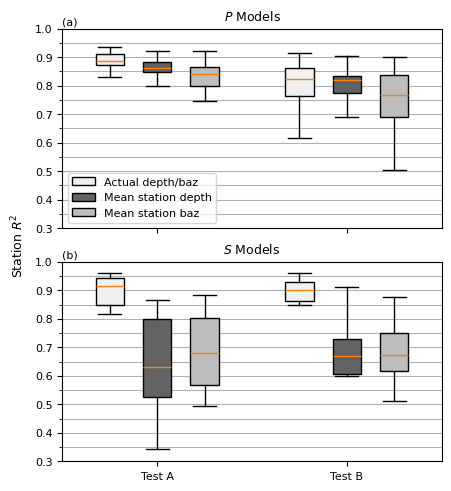

In [14]:
plotting.r2_boxplots(boxplots_dict,
                     scatter_dict,
                     label_dict,
                     xtick_locs=[0, 1],
                     xlims=[-0.25, 1.75],
                     plot_train=False,
                     ylim=[0.3, 1.0],
                     legend_ax=0,
                     savefigname='../figures/stationMeanDistFeaturesR2Boxplots.png',
                     figsize=(4.4, 4.8))

In [18]:
p_results[['test_r2', 'holdout_r2']].median()

test_r2       0.887
holdout_r2    0.822
dtype: float64

In [16]:
p_depth_r2_df.median()

test_r2       0.863272
holdout_r2    0.819615
dtype: float64

In [19]:
p_baz_r2_df.median()

test_r2       0.839883
holdout_r2    0.768264
dtype: float64

In [29]:
print('depth:', p_results['test_r2'].median() - p_depth_r2_df['test_r2'].median())
print('baz:', p_results['test_r2'].median() - p_baz_r2_df['test_r2'].median())

depth: 0.023727703984958604
baz: 0.04711734770592513


In [26]:
print('depth:', p_results['holdout_r2'].median() - p_depth_r2_df['holdout_r2'].median())
print('baz:', p_results['holdout_r2'].median() - p_baz_r2_df['holdout_r2'].median())

depth: 0.00238485994247839
baz: 0.053736287669150395


S

In [20]:
s_results[['test_r2', 'holdout_r2']].median()

test_r2       0.9155
holdout_r2    0.9020
dtype: float64

In [21]:
s_depth_r2_df.median()

test_r2       0.632514
holdout_r2    0.670633
dtype: float64

In [22]:
p_baz_r2_df.median()

test_r2       0.839883
holdout_r2    0.768264
dtype: float64

In [27]:
print('depth:', s_results['test_r2'].median() - s_depth_r2_df['test_r2'].median())
print('baz:', s_results['test_r2'].median() - s_baz_r2_df['test_r2'].median())

depth: 0.28298611945718255
baz: 0.23705000790408004


In [28]:
print('depth:', s_results['holdout_r2'].median() - s_depth_r2_df['holdout_r2'].median())
print('baz:', s_results['holdout_r2'].median() - s_baz_r2_df['holdout_r2'].median())

depth: 0.23136654384139288
baz: 0.22991979506229754
